# Calibrate AVHRR NDVI to match MODIS NDVI

to-do:

**Test GAM with extra features**

- Overloads memory and never finishes?
- Test removing one of the s(TOD) term from GAM and replace with s(MODIS_mean) - same issue with memory/not finishing

**Add MODIS summary stats to the models**
- With LBGM this has the effect of increasing the R-squared, but at the cost of IAV variability, seasonal variability is decent but it doesn't change with climate variability.
- Adding extra features like the std.dev., min and max NDVI from MODIS didn't change these results

**Models for forest, no-forest (no other changes)**
- GAM: This improves the r-squared of forested regions, but makes no difference to the non-trees region.
    - It'll be annoying/difficult to seperate the regions in practice because the output of the trees model removes cooridinates where there are no trees.
- As an aggregated time-series, the GAM model looks better than the LGBM model, but as one-to-one plots the acc. metrics are significantly better for the LGBM
- The aus-wide GAM model looks really good as an aggregated time-series (averaged over all the trees regions), yet the acc. statistics are substantially worse than the other methods

**Add climate features to the models**
- LGBM: MODIS summary stats + rainfall, vpd, and srad...this seems to work pretty well and outperforms every other model (best r2 and mae)
- Run GAM with climate variables, especially rainfall and srad for 'trees' region. - memory problems


**Test with GIMMS NDVI data**

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
from scipy import stats
import geopandas as gpd
from pprint import pprint
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import lightgbm as lgbm
from lightgbm import LGBMRegressor

import shap
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Analysis parameters


In [2]:
model_var='NDVI'
n_samples = 30000
n_val = 5000
name = 'nontrees'

### Assemble datasets for training and predicting

In [3]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_5km_monthly_1982_2013.nc')
ds = assign_crs(ds, crs ='epsg:3577')
ds = ds.sel(time=slice('2001', '2013'))
ds = ds.rename({'NDVI_median': 'NDVI_avhrr'})

mod = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/MODIS_NDVI_5km_monthly_2001_2022.nc')
mod = assign_crs(mod, crs ='epsg:3577')
mod = mod.sel(time=slice('2001', '2013'))
ds['NDVI_modis'] = mod['NDVI_median']

moy = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/MOY_5km_monthly_1982_2022.nc')['month']
moy = assign_crs(moy, crs ='epsg:4326')
moy=moy.sel(time=slice('2001', '2013'))
moy=moy.odc.reproject(how=ds.odc.geobox)
moy = moy.transpose('time','y','x')
ds['MOY'] = moy

rain_cml3 = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_cml3_5km_monthly_1982_2022.nc')['rain_cml3']
rain_cml3 = assign_crs(rain_cml3, crs ='epsg:4326')
rain_cml3=rain_cml3.sel(time=slice('2001', '2013'))
rain_cml3=rain_cml3.odc.reproject(how=ds.odc.geobox)
ds['rain_cml3'] = rain_cml3

rain_cml6 = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_cml6_5km_monthly_1982_2022.nc')['rain_cml6']
rain_cml6 = assign_crs(rain_cml6, crs ='epsg:4326')
rain_cml6=rain_cml6.sel(time=slice('2001', '2013'))
rain_cml6=rain_cml6.odc.reproject(how=ds.odc.geobox)
ds['rain_cml6'] = rain_cml6

rain_cml3_anom = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_cml3_anom_5km_monthly_1982_2022.nc')['rain_cml3_anom']
rain_cml3_anom = assign_crs(rain_cml3_anom, crs ='epsg:4326')
rain_cml3_anom=rain_cml3_anom.sel(time=slice('2001', '2013'))
rain_cml3_anom=rain_cml3_anom.odc.reproject(how=ds.odc.geobox)
ds['rain_cml3_anom'] = rain_cml3_anom

vpd = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/vpd_5km_monthly_1982_2022.nc')['vpd']
vpd = assign_crs(vpd, crs ='epsg:4326')
vpd=vpd.sel(time=slice('2001', '2013'))
vpd=vpd.odc.reproject(how=ds.odc.geobox)
ds['vpd'] = vpd

srad = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/srad_5km_monthly_1982_2022.nc')['srad']
srad = assign_crs(srad, crs ='epsg:4326')
srad=srad.sel(time=slice('2001', '2013'))
srad=srad.odc.reproject(how=ds.odc.geobox)
ds['srad'] = srad

tavg = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/tavg_5km_monthly_1982_2022.nc')['tavg']
tavg = assign_crs(tavg, crs ='epsg:4326')
tavg=tavg.sel(time=slice('2001', '2013'))
tavg=tavg.odc.reproject(how=ds.odc.geobox)
ds['tavg'] = tavg

CO2 = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/CO2_5km_monthly_1982_2022.nc')['CO2']
CO2 = assign_crs(CO2, crs ='epsg:4326')
CO2=CO2.sel(time=slice('2001', '2013'))
CO2=CO2.odc.reproject(how=ds.odc.geobox)
ds['CO2'] = CO2

mean_modis = ds['NDVI_modis'].mean('time')
mean_modis = mean_modis.expand_dims(time=ds.time)
ds['NDVI_modis_mean'] = mean_modis

ds = ds.where(ds['NDVI_modis_mean']>=0.1)
ds = ds.where(ds['n_obs']>=2)
ds = ds.drop(['NDVI_stddev', 'n_obs'])


### Mask for trees/no-trees mask

In [4]:
trees = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = assign_crs(trees, crs ='epsg:4326')
trees=trees.sel(time=slice('2001', '2018'))
trees=trees.odc.reproject(how=ds.odc.geobox)
trees = trees.mean('time')

if name=='trees':
    mask = xr.where(trees>0.5, 1, 0)
if name=='nontrees':
    mask = xr.where(trees<=0.5, 1, 0)

In [5]:
ds = ds.where(mask)

## Training & testing data: equal random sampling of bioclimatic regions

Can skip to importing TD if already run this

In [6]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [7]:
# Dictionary to save results 
results = []
for index, row in gdf.iterrows():

    if name=='trees':
        n=int(n_samples/5)
    if name=='nontrees':
        n=int(n_samples/6)
        
    if (name=='trees') & (row['region_name']=='Desert'):
        pass

    else:
        print(row['region_name'], n)
        
        # Generate a polygon mask to keep only data within the polygon
        mask = xr_rasterize(gdf.iloc[[index]], ds)
        
        # Mask dataset to set pixels outside the polygon to `NaN`
        dss = ds.where(mask)
        
        #sample equivalent num of samples per region
        df = dss.to_dataframe().dropna().sample(n=n, random_state=0).reset_index()
        
        # Append results to a dictionary using the attribute
        # column as an key
        results.append(df)


Tropics 5000
Savanna 5000
Warm Temperate 5000
Cool Temperate 5000
Mediterranean 5000
Desert 5000


In [8]:
# df = ds.to_dataframe().dropna().sample(n=n_samples, random_state=0).reset_index()
df = pd.concat(results).reset_index(drop=True)
df['year'] = pd.DatetimeIndex(df['time']).year

In [9]:
df = df.drop(['time','spatial_ref'], axis=1)

### Independent validation samples

In [10]:
validation = df.sample(n=n_val, random_state=0)

In [11]:
df = df.drop(validation.index)
print(len(df), 'training samples')

25000 training samples


### Plot the location of the samples

In [12]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:3577"
)

gdf_val = gpd.GeoDataFrame(
    validation, geometry=gpd.points_from_xy(validation.x, validation.y), crs="EPSG:3577"
)

In [13]:
gdf = gdf.drop(['x'], axis=1)
gdf_val = gdf_val.drop(['x'], axis=1)

# gdf_val.explore(column='year', cmap='inferno')

In [14]:
# gdf.plot(column='year', figsize=(8,8), markersize=1)

In [15]:
# gdf.to_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_training_data.shp')
# gdf_val.to_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_validation_data.shp')

### Import training data if skipping above

In [16]:
# gdf = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_training_data.shp')
# gdf_val = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/'+model_var+'_validation_data.shp')

In [17]:
df = pd.DataFrame(gdf.drop(columns='geometry', axis=1))
validation = pd.DataFrame(gdf_val.drop(columns='geometry', axis=1))

df = df.drop(['year'], axis=1)
validation = validation.drop(['year'], axis=1)

y = df['NDVI_modis']
x = df.drop(['NDVI_modis'], axis=1)

## Testing model using nested CV

In [18]:
# Create the parameter grid using distributions
param_grid = {
    'num_leaves': stats.randint(5,50),
    'min_child_samples':stats.randint(10,30),
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': stats.randint(5,25),
    'n_estimators': [300, 400, 500],
}

In [19]:
outer_cv = KFold(n_splits=5, shuffle=True,
                   random_state=0)

# lists to store results of CV testing
acc = []
rmse=[]
r2=[]

i = 1
for train_index, test_index in outer_cv.split(x, y):
    print(f"Working on {i}/5 outer CV split", end='\r')
    model = LGBMRegressor(random_state=1,
                          verbose=-1,
                          # n_jobs=-1
                          )

    # index training, testing
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    #simple random split on inner fold
    inner_cv = KFold(n_splits=3,
                     shuffle=True,
                     random_state=0)
    
    clf = RandomizedSearchCV(
                   model,
                   param_grid,
                   verbose=0,
                   n_iter=100,
                   # n_jobs=-1,
                   cv=inner_cv.split(X_tr, y_tr)
                  )
    
    #prevents extensive print statements
    clf.fit(X_tr, y_tr, callbacks=None)
    
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # MAE
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # RMSE
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #1:1 plots for each fold (save to csv so we can make a plot later on)
    df = pd.DataFrame({'Test':y_tt, 'Pred':pred}).reset_index(drop=True)

    df.to_csv("/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/cross_validation/"+str(i)+"_NDVI_lgbm_"+name+".csv")
    
    i += 1

### Create a single 1:1 plot out of the folds 


In [20]:
dffs=[]
for i in range(1,5+1):
    df = pd.read_csv("/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/cross_validation/"+str(i)+"_NDVI_lgbm_"+name+".csv",
                     usecols=['Test', 'Pred'])
    dffs.append(df)

cross_df = pd.concat(dffs)

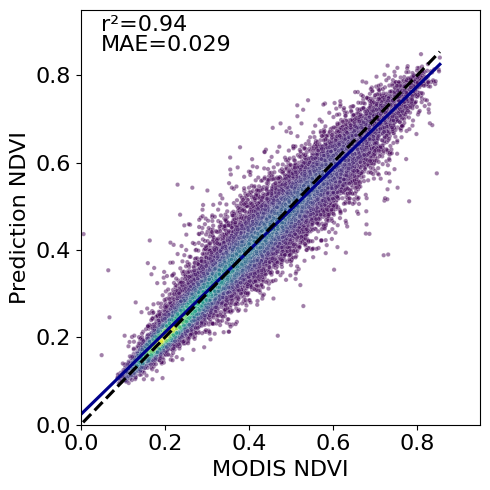

In [21]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred',c=z, s=10, lw=1, alpha=0.5, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
# plt.colorbar()
plt.xlabel('MODIS '+model_var, fontsize=16)
plt.ylabel('Prediction '+model_var, fontsize=16)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.2g}'.format(np.mean(acc)),
            transform=ax.transAxes, fontsize=16)

if model_var=='NDVI':
    ax.set_ylim(0.0, 0.95)
    ax.set_xlim(0.0, 0.95)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/cross_validation/cross_val_NDVI_lgbm_"+name+".png",
            bbox_inches='tight', dpi=300)

## Optimize model using all training data

Using a randomized strategy so we can search through more variables, with 500 iterations


In [22]:
outer_cv = KFold(n_splits=5, shuffle=True,
                   random_state=0)

clf = RandomizedSearchCV(LGBMRegressor(verbose=-1),
                   param_grid,
                   verbose=1,
                   n_iter=500,
                   # n_jobs=-1,
                   cv=outer_cv
                  )

clf.fit(x, y, callbacks=None)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=LGBMRegressor(verbose=-1), n_iter=500,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14c12cd2c6a0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14c12cabb0d0>,
                                        'n_estimators': [300, 400, 500],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14c18bb725b0>},
                   verbose=1)

In [23]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The best score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'boosting_type': 'gbdt',
 'max_depth': 19,
 'min_child_samples': 19,
 'n_estimators': 500,
 'num_leaves': 44}


The best score using these parameters is: 
0.94


## Fit on all data using best params

In [24]:
model = LGBMRegressor(**clf.best_params_)

model.fit(x,y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 13
[LightGBM] [Info] Start training from score 0.383333


LGBMRegressor(max_depth=19, min_child_samples=19, n_estimators=500,
              num_leaves=44)

## Compare with independent validation data

In [25]:
y_val = validation['NDVI_modis']
x_val = validation.drop(['NDVI_modis'], axis=1)

In [26]:
pred = model.predict(x_val)

r2 = r2_score(y_val, pred)
ac = mean_absolute_error(y_val, pred)
df_val = pd.DataFrame({'Test':y_val, 'Pred':pred}).reset_index(drop=True)

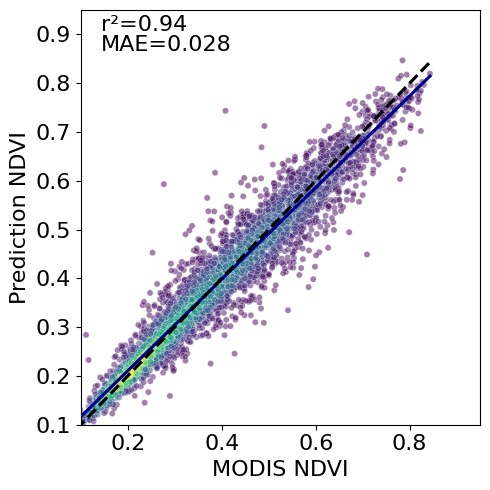

In [27]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

xy = np.vstack([df_val['Test'],df_val['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=df_val, x='Test',y='Pred',c=z, s=20, lw=1, alpha=0.5, ax=ax, legend=True)
sb.regplot(data=df_val, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=df_val, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

plt.xlabel('MODIS '+model_var, fontsize=16)
plt.ylabel('Prediction '+model_var, fontsize=16)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.2g}'.format(ac),
            transform=ax.transAxes, fontsize=16)

if model_var=='NDVI':
    ax.set_ylim(0.1, 0.95)
    ax.set_xlim(0.1, 0.95)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/cross_validation/validation_NDVI_lgbm_"+name+".png",
            bbox_inches='tight', dpi=300)

### Save the model

In [28]:
dump(model, '/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/Harmonization_LGBM_'+name+'.joblib')

['/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/Harmonization_LGBM_nontrees.joblib']

## Examine feature importance using SHAP


In [29]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [30]:
vals= np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['col_name'] = feature_importance['col_name'].str.removesuffix("_RS")

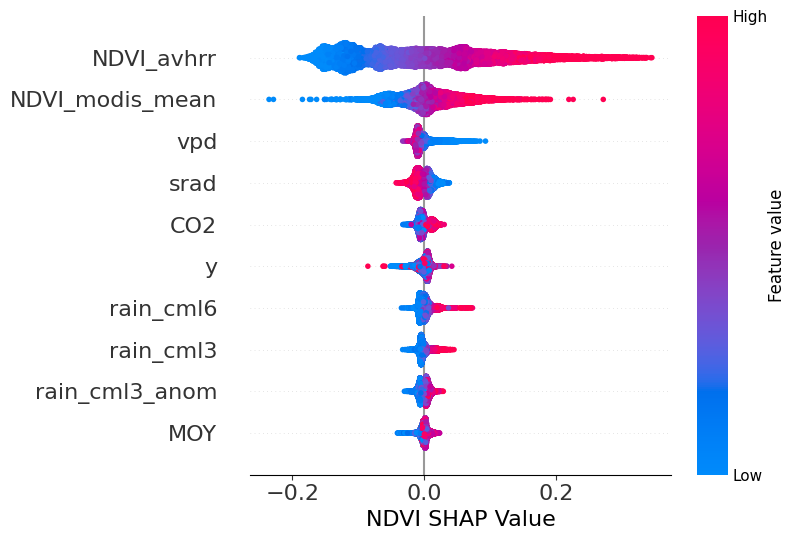

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5,7))
shap.summary_plot(shap_values, max_display=10, show=False, feature_names=feature_importance['col_name'])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel(model_var+' SHAP Value', fontsize=16)
plt.tight_layout()

fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/cross_validation/feature_importance_NDVI_lgbm_"+name+".png",
            bbox_inches='tight', dpi=300)